In [2]:
text = 'You say goodbye and I say hello.'

text = text.lower()
text = text.replace('.', ' .')
text

'you say goodbye and i say hello .'

In [3]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [4]:
word_to_id = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id) # 현재는 빈 상태이므로 len() = 0 -> 1씩 증가
        word_to_id[word] = new_id

id_to_word = {id_: word for word, id_ in word_to_id.items()}

In [5]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [6]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [7]:
id_to_word[1]

'say'

In [8]:
import numpy as np

corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus


array([0, 1, 2, 3, 4, 1, 5, 6])

In [10]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)
corpus, word_to_id, id_to_word

(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

In [ ]:
# 동시 발생 매트릭스

def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

In [11]:
def cos_similarity(x, y, eps=1e-8): #eps:0으로 나누는 것 방지하기 위해 작은 수(에ㅂ실론)를 더함
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)

    return np.dot(nx, ny)

In [12]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067758832467


In [13]:
# 유사 단어의 랭킹 표시

def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 1. 검색어를 꺼낸다
    if query not in word_to_id:
        print(f'{query}(을)를 찾을 수 없습니다.')
        return
    
    print(f'\n[query] {query}')
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 2. 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 3. 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort(): # -1을 곱해서 내림차순으로 정렬
        if id_to_word[i] == query:
            continue
        print(f'{id_to_word[i]} : {similarity[i]}')

        count += 1
        if count >= top:
            return

In [14]:
# argsort 예시

x = np.array([100, -20, 2])
x.argsort()

# 결과 해석 => 값이 작은 것부터 인덱스 출력(-20, 2, 100)

array([1, 2, 0])

In [15]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


In [16]:
# PPMI(양의 상호 정보량)

def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps) # eps(엡실론)을 더해서 0으로 나누는 것 방지
            M[i, j] = max(0, pmi) # 음수는 0으로 취급

            if verbose:
                cnt+=1
                if cnt % (total//100) == 0: # // : 몫,  % : cnt 가 (total//100) 으로 나눈 나머지가 0일 때 
                    print('%.1f%% 완료' % (100*cnt/total))
    
    return M

In [17]:
# 동시발생 행렬 -> PPMI 행렬

import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) #유효 자릿수를 세자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0]
 [1 0 1 0 1 1]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 0 0]
 [0 1 0 0 0 0]]
--------------------------------------------------
PPMI
[[0.    1.585 0.    0.    0.    0.   ]
 [1.585 0.    0.585 0.    0.585 1.585]
 [0.    0.585 0.    1.585 0.    0.   ]
 [0.    0.    1.585 0.    1.585 0.   ]
 [0.    0.585 0.    1.585 0.    0.   ]
 [0.    1.585 0.    0.    0.    0.   ]]


## SVD 차원 감소

In [18]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

In [24]:
print(f'동시발생\n', C[0])
print('\n') 
print(f'PPMI\n', W[0])
print('\n')
print(f'SVD\n', U[0]) # 희소벡터였던 W[0]가 SVD에 의해 밀집벡터 U[0]으로 변함
print('\n')
print(f'2차원으로 감소\n', U[0, :2]) # 2차원 벡터로 줄이기(차원 감소)

동시발생
 [0 1 0 0 0 0 0]


PPMI
 [0.    1.807 0.    0.    0.    0.    0.   ]


SVD
 [ 3.409e-01  0.000e+00  1.205e-01 -3.608e-16 -1.110e-16  9.323e-01
  1.626e-16]


2차원으로 감소
 [0.341 0.   ]


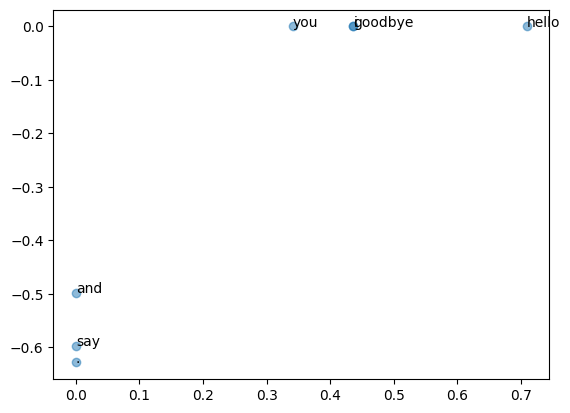

In [25]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

In [26]:
#PTB(Penn Treebank 펜 트리뱅크 말뭉치)

import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기 : ', len(corpus))
print('corpus[:30] : ', corpus[:30])
print()
print('id_to_word[0] : ', id_to_word[0])
print('id_to_word[1] : ', id_to_word[1])
print('id_to_word[2] : ', id_to_word[2])
print()
print("word_to_id['car'] : ", word_to_id['car'])
print("word_to_id['happy'] : ", word_to_id['happy'])
print("word_to_id['lexus'] : ", word_to_id['lexus'])

Done
말뭉치 크기 :  929589
corpus[:30] :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0] :  aer
id_to_word[1] :  banknote
id_to_word[2] :  berlitz

word_to_id['car'] :  3856
word_to_id['happy'] :  4428
word_to_id['lexus'] :  7426


In [27]:
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시 발생 수 계산...')
C = create_co_matrix(corpus, vocab_size, window_size)

print('PPMI 계산...')
W = ppmi(C, verbose=True)

print('SVD 계산...')
try:
    #truncated SVD(고속)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)

except ImportError:
    #SVD
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']

for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시 발생 수 계산...
PPMI 계산...
1.00 완료
2.00 완료
3.00 완료
4.00 완료
5.00 완료
6.00 완료
7.00 완료
8.00 완료
9.00 완료
10.00 완료
11.00 완료
12.00 완료
13.00 완료
14.00 완료
15.00 완료
16.00 완료
17.00 완료
18.00 완료
19.00 완료
20.00 완료
21.00 완료
22.00 완료
23.00 완료
24.00 완료
25.00 완료
26.00 완료
27.00 완료
28.00 완료
29.00 완료
30.00 완료
31.00 완료
32.00 완료
33.00 완료
34.00 완료
35.00 완료
36.00 완료
37.00 완료
38.00 완료
39.00 완료
40.00 완료
41.00 완료
42.00 완료
43.00 완료
44.00 완료
45.00 완료
46.00 완료
47.00 완료
48.00 완료
49.00 완료
50.00 완료
51.00 완료
52.00 완료
53.00 완료
54.00 완료
55.00 완료
56.00 완료
57.00 완료
58.00 완료
59.00 완료
60.00 완료
61.00 완료
62.00 완료
63.00 완료
64.00 완료
65.00 완료
66.00 완료
67.00 완료
68.00 완료
69.00 완료
70.00 완료
71.00 완료
72.00 완료
73.00 완료
74.00 완료
75.00 완료
76.00 완료
77.00 완료
78.00 완료
79.00 완료
80.00 완료
81.00 완료
82.00 완료
83.00 완료
84.00 완료
85.00 완료
86.00 완료
87.00 완료
88.00 완료
89.00 완료
90.00 완료
91.00 완료
92.00 완료
93.00 완료
94.00 완료
95.00 완료
96.00 완료
97.00 완료
98.00 완료
99.00 완료
100.00 완료
SVD 계산...

[query] you
 i: 0.7003179788589478
 we: 0.6367183923721313
 anybody: 0.5